In [7]:
import numpy as np
import math
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

Qatar_map = mpimg.imread("/content/drive/MyDrive/Colab Notebooks/Qatar.png")
def show_cities(path, w=12, h=8):
    """Plot a TSP path overlaid on a map of the Qatar & their capitals."""
    if isinstance(path, dict):      path = list(path.values())
    if isinstance(path[0][0], str): path = [ item[1] for item in path ]    
    plt.imshow(united_states_map)    
    for x0, y0 in path:
        plt.plot(x0, y0, 'y*', markersize=15)  # y* = yellow star for starting point        
    plt.axis("off")
    fig = plt.gcf()
    fig.set_size_inches([w, h])

    
def show_path(path, starting_city=None, w=12, h=8):
    """Plot a TSP path overlaid on a map of the Qatar & their capitals."""
    if isinstance(path, dict):      path = list(path.values())
    if isinstance(path[0][0], str): path = [ item[1] for item in path ]
    
    starting_city = starting_city or path[0]
    x, y = list(zip(*path))
    #_, (x0, y0) = starting_city
    (x0, y0) = starting_city
    plt.imshow(Qatar_map)
    #plt.plot(x0, y0, 'y*', markersize=15)  # y* = yellow star for starting point
    plt.plot(x + x[:1], y + y[:1])  # include the starting point at the end of path
    plt.axis("off")
    fig = plt.gcf()
    fig.set_size_inches([w, h])
    
    
def polyfit_plot(x,y,deg, **kwargs):
    coefficients = np.polyfit(x,y,deg,**kwargs)
    poly  = np.poly1d(coefficients)
    new_x = np.linspace(x[0], x[-1])
    new_y = poly(new_x)
    plt.plot(x, y, "o", new_x, new_y)
    plt.xlim([x[0]-1, x[-1] + 1 ])
    
    terms = []
    for p, c in enumerate(reversed(coefficients)):
        term = str(round(c,1))
        if p == 1: term += 'x'
        if p >= 2: term += 'x^'+str(p)
        terms.append(term)        
    plt.title(" + ".join(reversed(terms)))  

In [8]:
def distance(xy1, xy2) -> float:
    if isinstance(xy1[0], str): xy1 = xy1[1]; xy2 = xy2[1];               # if xy1 == ("Name", (x,y))
    return math.sqrt( (xy1[0]-xy2[0])**2 + (xy1[1]-xy2[1])**2 )

def path_distance(path) -> int:
    if isinstance(path, dict):      path = list(path.values())            # if path == {"Name": (x,y)}
    if isinstance(path[0][0], str): path = [ item[1] for item in path ]   # if path == ("Name", (x,y))
    return int(sum(
        [ distance(path[i],  path[i+1]) for i in range(len(path)-1) ]
      + [ distance(path[-1], path[0]) ]                                   # include cost of return journey
    ))

7


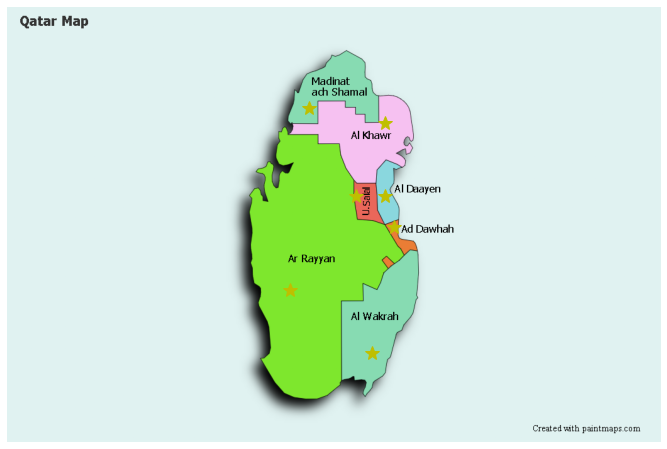

In [9]:
cities = {"Ar Rayyan": (450, 450), "Al Dawhah": (615, 350), "U. Salal": (555, 300), "Al Daayen": (600, 300),"Al Khawar": (600, 185), "Madinat ash Shamal": (480, 160), "Al Wakrah": (580, 550) }
cities = list(sorted(cities.items()))
print(len(cities))
show_cities(cities)

1242

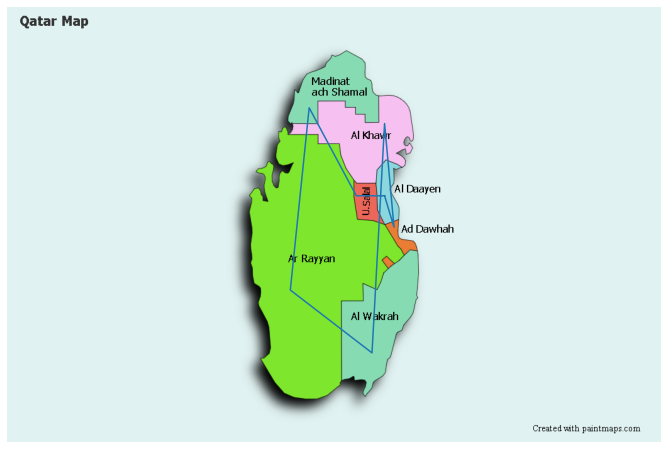

In [10]:
show_path(cities)
path_distance(cities)

In [11]:
import time
from itertools import chain
from typing import Any, Callable, List, Tuple, Union

import numpy as np
import random



class AntColonySolver:
    def __init__(self,
                 cost_fn:                 Callable[[Any,Any], Union[float,int]],                         
                 
                 time=0,                  # run for a fixed amount of time
                 min_time=0,              # minimum runtime
                 timeout=0,               # maximum time in seconds to run for
                 stop_factor=2,           # how many times to redouble effort after new new best path
                 min_round_trips=10,      # minimum number of round trips before stopping
                 max_round_trips=0,       # maximum number of round trips before stopping                 
                 min_ants=0,              # Total number of ants to use
                 max_ants=0,              # Total number of ants to use
                 
                 ant_count=64,            # this is the bottom of the near-optimal range for numpy performance
                 ant_speed=1,             # how many steps do ants travel per epoch

                 distance_power=1,        # power to which distance affects pheromones                 
                 pheromone_power=1.25,    # power to which differences in pheromones are noticed
                 decay_power=0,           # how fast do pheromones decay
                 reward_power=0,          # relative pheromone reward based on best_path_length/path_length 
                 best_path_smell=2,       # queen multiplier for pheromones upon finding a new best path                  
                 start_smell=0,           # amount of starting pheromones [0 defaults to `10**self.distance_power`]

                 verbose=False,

    ):
        assert callable(cost_fn)        
        self.cost_fn         = cost_fn
        self.time            = int(time)
        self.min_time        = int(min_time)
        self.timeout         = int(timeout)
        self.stop_factor     = float(stop_factor)
        self.min_round_trips = int(min_round_trips)
        self.max_round_trips = int(max_round_trips)
        self.min_ants        = int(min_ants)
        self.max_ants        = int(max_ants)
    
        self.ant_count       = int(ant_count)
        self.ant_speed       = int(ant_speed)
        
        self.distance_power  = float(distance_power)     
        self.pheromone_power = float(pheromone_power)
        self.decay_power     = float(decay_power)
        self.reward_power    = float(reward_power)
        self.best_path_smell = float(best_path_smell)
        self.start_smell     = float(start_smell or 10**self.distance_power)
        
        self.verbose         = int(verbose)
        self._initalized     = False
        
        if self.min_round_trips and self.max_round_trips: self.min_round_trips = min(self.min_round_trips, self.max_round_trips)
        if self.min_ants and self.max_ants:               self.min_ants        = min(self.min_ants, self.max_ants)


    def solve_initialize(
            self,
            problem_path: List[Any],
    ) -> None:
        ### Cache of distances between nodes
        self.distances = {
            source: {
                dest: self.cost_fn(source, dest)
                for dest in problem_path
            }
            for source in problem_path
        }

        ### Cache of distance costs between nodes - division in a tight loop is expensive
        self.distance_cost = {
            source: {
                dest: 1 / (1 + self.distances[source][dest]) ** self.distance_power
                for dest in problem_path
            }
            for source in problem_path
        }

        ### This stores the pheromone trail that slowly builds up
        self.pheromones = {
            source: {
                # Encourage the ants to start exploring in all directions and furthest nodes
                dest: self.start_smell
                for dest in problem_path
            }
            for source in problem_path
        }
        
        ### Sanitise input parameters
        if self.ant_count <= 0:
            self.ant_count = len(problem_path)
        if self.ant_speed <= 0:
            self.ant_speed = np.median(list(chain(*[ d.values() for d in self.distances.values() ]))) // 5
        self.ant_speed = int(max(1,self.ant_speed))
        
        ### Heuristic Exports
        self.ants_used   = 0
        self.epochs_used = 0
        self.round_trips = 0
        self._initalized = True        


    def solve(self,
              problem_path: List[Any],
              restart=False,
    ) -> List[Tuple[int,int]]:
        if restart or not self._initalized:
            self.solve_initialize(problem_path)

        ### Here come the ants!
        ants = {
            "distance":    np.zeros((self.ant_count,)).astype('int32'),
            "path":        [ [ problem_path[0] ]   for n in range(self.ant_count) ],
            "remaining":   [ set(problem_path[1:]) for n in range(self.ant_count) ],
            "path_cost":   np.zeros((self.ant_count,)).astype('int32'),
            "round_trips": np.zeros((self.ant_count,)).astype('int32'),
        }

        best_path       = None
        best_path_cost  = np.inf
        best_epochs     = []
        epoch           = 0
        time_start      = time.perf_counter()
        while True:
            epoch += 1

            ### Vectorized walking of ants
            # Small optimization here, testing against `> self.ant_speed` rather than `> 0` 
            #       avoids computing ants_arriving in the main part of this tight loop
            ants_travelling = (ants['distance'] > self.ant_speed)
            ants['distance'][ ants_travelling ] -= self.ant_speed
            if all(ants_travelling):
                continue  # skip termination checks until the next ant arrives
            
            ### Vectorized checking of ants arriving
            ants_arriving       = np.invert(ants_travelling)
            ants_arriving_index = np.where(ants_arriving)[0]
            for i in ants_arriving_index:

                ### ant has arrived at next_node
                this_node = ants['path'][i][-1]
                next_node = self.next_node(ants, i)
                ants['distance'][i]  = self.distances[ this_node ][ next_node ]
                ants['remaining'][i] = ants['remaining'][i] - {this_node}
                ants['path_cost'][i] = ants['path_cost'][i] + ants['distance'][i]
                ants['path'][i].append( next_node )

                ### ant has returned home to the colony
                if not ants['remaining'][i] and ants['path'][i][0] == ants['path'][i][-1]:
                    self.ants_used  += 1
                    self.round_trips = max(self.round_trips, ants["round_trips"][i] + 1)

                    ### We have found a new best path - inform the Queen
                    was_best_path = False
                    if ants['path_cost'][i] < best_path_cost:
                        was_best_path  = True
                        best_path_cost = ants['path_cost'][i]
                        best_path      = ants['path'][i]
                        best_epochs   += [ epoch ]
                        if self.verbose:
                            print({
                                "path_cost":   int(ants['path_cost'][i]),
                                "ants_used":   self.ants_used,
                                "epoch":       epoch,
                                "round_trips": ants['round_trips'][i] + 1,
                                "clock":       int(time.perf_counter() - time_start),
                            })

                    ### leave pheromone trail
                    # doing this only after ants arrive home improves initial exploration
                    #  * self.round_trips has the effect of decaying old pheromone trails
                    # ** self.reward_power = -3 has the effect of encouraging ants to explore longer routes
                    #                           in combination with doubling pheromone for best_path
                    reward = 1
                    if self.reward_power: reward *= ((best_path_cost / ants['path_cost'][i]) ** self.reward_power)
                    if self.decay_power:  reward *= (self.round_trips ** self.decay_power)
                    for path_index in range( len(ants['path'][i]) - 1 ):
                        this_node = ants['path'][i][path_index]
                        next_node = ants['path'][i][path_index+1]
                        self.pheromones[this_node][next_node] += reward
                        self.pheromones[next_node][this_node] += reward
                        if was_best_path:
                            # Queen orders to double the number of ants following this new best path                            
                            self.pheromones[this_node][next_node] *= self.best_path_smell
                            self.pheromones[next_node][this_node] *= self.best_path_smell


                    ### reset ant
                    ants["distance"][i]     = 0
                    ants["path"][i]         = [ problem_path[0] ]
                    ants["remaining"][i]    = set(problem_path[1:])
                    ants["path_cost"][i]    = 0
                    ants["round_trips"][i] += 1


            ### Do we terminate?
            
            # Always wait for at least 1 solutions (note: 2+ solutions are not guaranteed)
            if not len(best_epochs): continue 
            
            # Timer takes priority over other constraints
            if self.time or self.min_time or self.timeout:
                clock = time.perf_counter() - time_start
                if self.time:
                    if clock > self.time: break
                    else:                 continue
                if self.min_time and clock < self.min_time: continue
                if self.timeout  and clock > self.timeout:  break
            
            # First epoch only has start smell - question: how many epochs are required for a reasonable result?
            if self.min_round_trips and self.round_trips <  self.min_round_trips: continue        
            if self.max_round_trips and self.round_trips >= self.max_round_trips: break

            # This factor is most closely tied to computational power                
            if self.min_ants and self.ants_used <  self.min_ants: continue        
            if self.max_ants and self.ants_used >= self.max_ants: break            
            
            # Lets keep redoubling our efforts until we can't find anything more
            if self.stop_factor and epoch > (best_epochs[-1] * self.stop_factor): break
                                
            # Nothing else is stopping us: Queen orders the ants to continue!      
            if True: continue
            
            
            
        ### We have (hopefully) found a near-optimal path, report back to the Queen
        self.epochs_used = epoch
        self.round_trips = np.max(ants["round_trips"])
        return best_path


    def next_node(self, ants, index):
        this_node   = ants['path'][index][-1]

        weights     = []
        weights_sum = 0
        if not ants['remaining'][index]: return ants['path'][index][0]  # return home
        for next_node in ants['remaining'][index]:
            if next_node == this_node: continue
            reward = (
                    self.pheromones[this_node][next_node] ** self.pheromone_power
                    * self.distance_cost[this_node][next_node]  # Prefer shorter paths
            )
            weights.append( (reward, next_node) )
            weights_sum   += reward

        # Pick a random path in proportion to the weight of the pheromone
        rand = random.random() * weights_sum
        for (weight, next_node) in weights:
            if rand > weight: rand -= weight
            else:             break
        return next_node
            
        
def AntColonyRunner(cities, verbose=False, plot=False, label={}, algorithm=AntColonySolver, **kwargs):
    solver     = algorithm(cost_fn=distance, verbose=verbose, **kwargs)
    start_time = time.perf_counter()
    result     = solver.solve(cities)
    stop_time  = time.perf_counter()
    if label: kwargs = { **label, **kwargs }
        
    for key in ['verbose', 'plot', 'animate', 'label', 'min_time', 'max_time']:
        if key in kwargs: del kwargs[key]
    print("N={:<3d} | {:5.0f} -> {:4.0f} | {:4.0f}s | ants: {:5d} | trips: {:4d} | "
          .format(len(cities), path_distance(cities), path_distance(result), (stop_time - start_time), solver.ants_used, solver.round_trips)
          + " ".join([ f"{k}={v}" for k,v in kwargs.items() ])
    )
    if plot:
        show_path(result)
    return result

{'path_cost': 1080, 'ants_used': 1, 'epoch': 832, 'round_trips': 1, 'clock': 0}
{'path_cost': 1052, 'ants_used': 4, 'epoch': 842, 'round_trips': 1, 'clock': 0}
{'path_cost': 1018, 'ants_used': 11, 'epoch': 905, 'round_trips': 1, 'clock': 0}
{'path_cost': 1000, 'ants_used': 19, 'epoch': 950, 'round_trips': 1, 'clock': 0}
N=7   |  1242 -> 1001 |    0s | ants:   558 | trips:   10 | distance_power=1


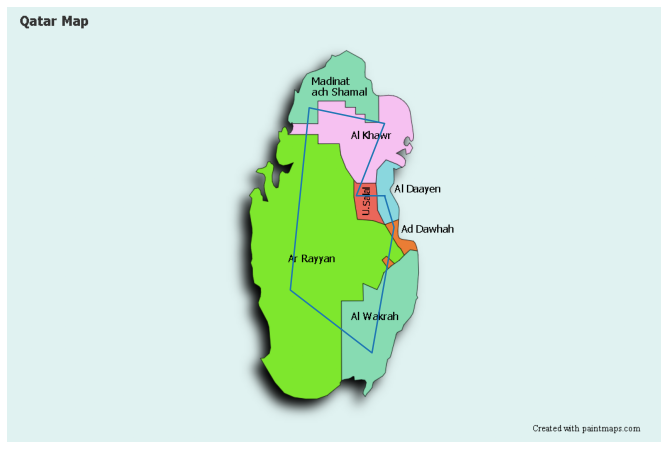

In [12]:
results = AntColonyRunner(cities, distance_power=1, verbose=True, plot=True)